In [1]:
import torch
from torch import nn
import torch.quantization
import pytorch_lightning as pl
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint, Callback
from pytorch_lightning.loggers import TensorBoardLogger
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import pandas as  pd

In [2]:
def plot_data_hist(df):
    # Define figure size and layout for subplots
    fig, axs = plt.subplots(3, 2, figsize=(15, 15), dpi=80)

    # List of columns to plot histograms for
    columns = df.columns

    # Loop over the axes and columns to create histograms
    for ax, col in zip(axs.ravel(), columns):
        ax.hist(df[col], bins=200)
        ax.set_xlabel(col)
        ax.set_ylabel('count')

    # Adjust layout for better readability
    plt.tight_layout()
    plt.show()


layers | max :  951 | min:  1
all_parameters | max :  4569266643.0 | min:  805.0
all_activations | max :  2028151 | min:  1
batch_size | max :  2048 | min:  32
real_memory_usage | max :  39229 | min:  1045
len dataset:  1086


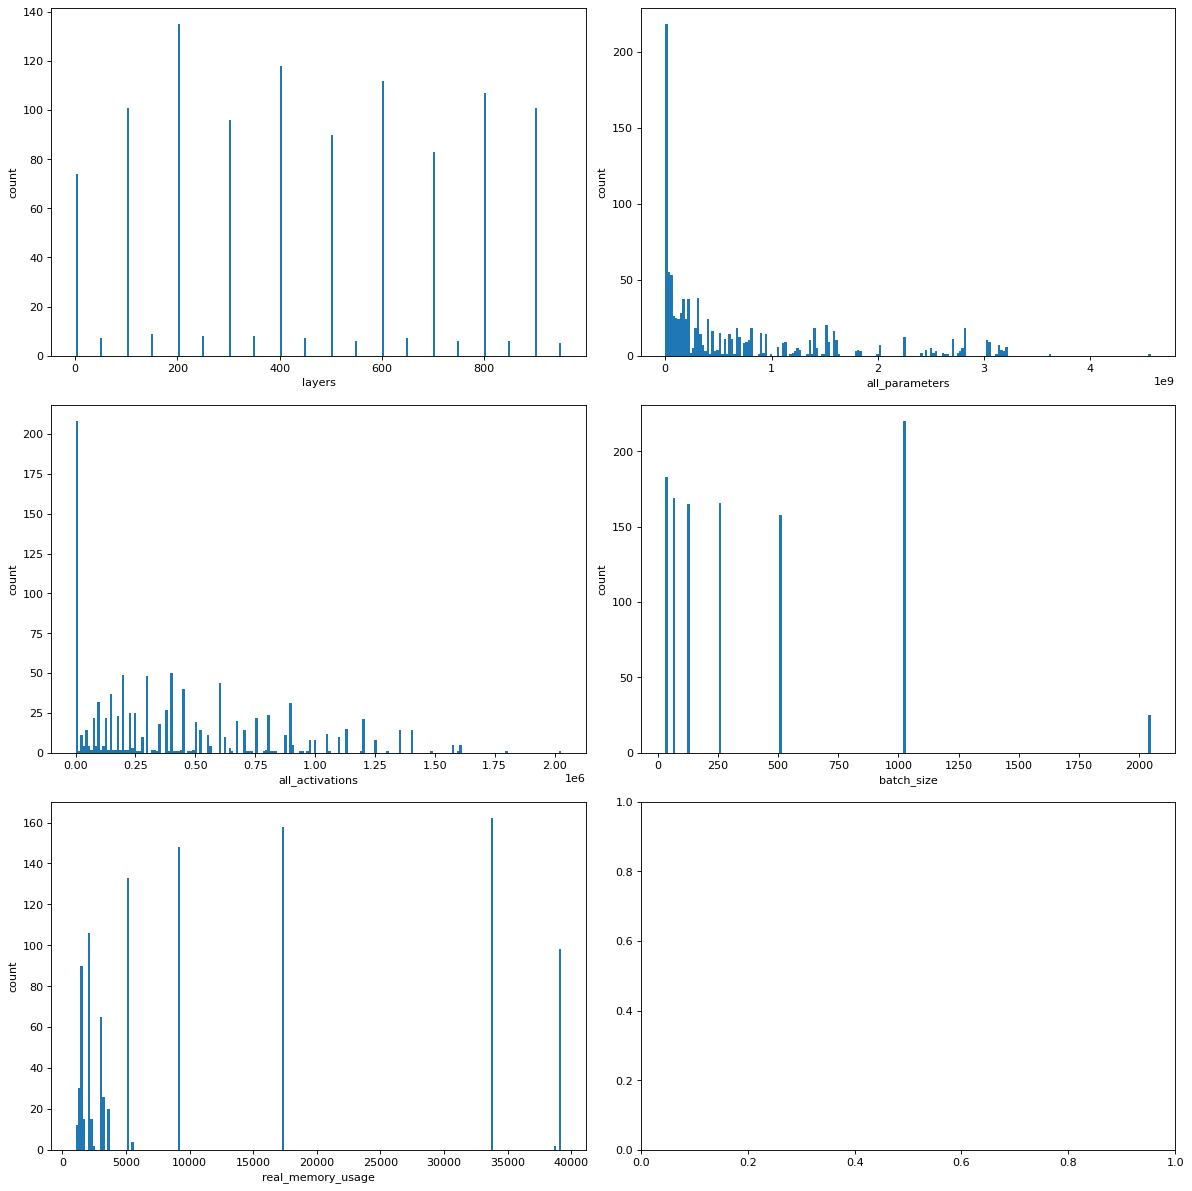

In [3]:
csv_file_path = "/home/reza/gpu_utilization/data/fc_data_GPU_memory_extensive.csv"  

# Load the CSV into a DataFrame and assign it to the desired column names
df = pd.read_csv(csv_file_path)
df = df[['#layers', 'params_total', '#neurons', 'batch_size', 'gpumemory_max' ]]
df['#neurons'] = df['#neurons'] * df['#layers']
df_cleaned = df.dropna()
df = df_cleaned

# Map the existing columns to your desired column structure
df = df.rename(columns={
    'gpumemory_max': 'real_memory_usage',
    '#layers': 'layers',
    'batch_size': 'batch_size',
    'params_total': 'all_parameters',
    '#neurons': 'all_activations',
})

columns_to_analyze = ['layers', 'all_parameters', 'all_activations', 'batch_size', 'real_memory_usage']
for col in columns_to_analyze:
    if col == 'activation_function':
      continue
    print(f'{col} | max : ', df[col].max(), '| min: ', df[col].min())
print('len dataset: ', len(df))


plot_data_hist(df)

# classification

In [45]:
# bins = [i*2048 for i in range(10)]  # Define your bin edges
bins = [i*1000 for i in range(21)]  # Define your bin edges
print(bins)
bins.append(float('inf'))
labels = [i for i in range(len(bins)-1)]  # Labels corresponding to the bins

# Use pd.cut() to create a new column with labels based on the bins
df['memory_usage_label'] = pd.cut(df['real_memory_usage'], bins=bins, labels=labels, right=True)

print(df, df['memory_usage_label'], "| length of labels", len(labels))


# Check if there are any NaN values in a specific column
has_nan = df['memory_usage_label'].isna().any()

print(has_nan)  # True if NaN exists, False otherwise

[0, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000, 11000, 12000, 13000, 14000, 15000, 16000, 17000, 18000, 19000, 20000]
      layers  all_parameters  all_activations  batch_size  real_memory_usage  \
0          1    8.050000e+02                1          32               1237   
1          1    8.030500e+04              101          32               1493   
2          1    2.385100e+05              300          32               1497   
3          1    6.360100e+05              800          32               1505   
4          1    1.590010e+06             2000          32               1525   
...      ...             ...              ...         ...                ...   
1086     801    9.540831e+08           801801        2048              33761   
1087     801    2.031048e+09          1202301        2048              39227   
1088     901    1.543290e+05              901        2048               3039   
1089     901    3.022688e+08           451401        2048        

In [46]:
from sklearn.model_selection import train_test_split
x_train, x_temp, y_train, y_temp = train_test_split(df[['layers', 'batch_size', 'all_parameters', 'all_activations']].values, df['memory_usage_label'].values, test_size=0.3, random_state=42)

x_test, x_val, y_test, y_val = train_test_split(
    x_temp, y_temp, test_size=0.66, random_state=42)

print('total data size: ', len(df))
print(df)
print(f"train size {len(x_train)}, val size: {len(x_val)}, test size: {len(x_test)}")

total data size:  1086
      layers  all_parameters  all_activations  batch_size  real_memory_usage  \
0          1    8.050000e+02                1          32               1237   
1          1    8.030500e+04              101          32               1493   
2          1    2.385100e+05              300          32               1497   
3          1    6.360100e+05              800          32               1505   
4          1    1.590010e+06             2000          32               1525   
...      ...             ...              ...         ...                ...   
1086     801    9.540831e+08           801801        2048              33761   
1087     801    2.031048e+09          1202301        2048              39227   
1088     901    1.543290e+05              901        2048               3039   
1089     901    3.022688e+08           451401        2048              17379   
1090     901    1.054383e+09           901901        2048              33763   

     memory_usag

In [47]:
from torch.utils.data import Dataset, DataLoader

# Custom Dataset Class
class CustomDataset(Dataset):
    def __init__(self, inputs, targets):
        # Store the input and target data
        self.inputs = torch.tensor(inputs, dtype=torch.float32)
        self.targets = torch.tensor(targets, dtype=torch.float32)

    def __len__(self):
        # Returns the total number of samples
        return len(self.inputs)

    def __getitem__(self, idx):
        # Return a single sample (input, target pair)
        return self.inputs[idx], self.targets[idx]

train_dataloader = DataLoader(CustomDataset(x_train, y_train), 64, num_workers=0, shuffle=True)
val_dataloader = DataLoader(CustomDataset(x_val, y_val), 64, num_workers=0)
test_dataloader = DataLoader(CustomDataset(x_test, y_test),1, num_workers=0)
x, y = next(iter(train_dataloader))
print(f"input shape: {x.shape}, output shape: {y.shape}")

input shape: torch.Size([64, 4]), output shape: torch.Size([64])


In [48]:

class FC_base(nn.Module):
    def __init__(self, input_features=4, output_features=21, base_features=4):
        super(FC_base, self).__init__()

        # Define the network architecture
        self.fc1 = nn.Linear(input_features, base_features)  
        self.bn1 = nn.BatchNorm1d(base_features)            
        self.fc2 = nn.Linear(base_features, base_features)            
        self.bn2 = nn.BatchNorm1d(base_features)           
        self.fc3 = nn.Linear(base_features, base_features)             
        self.bn3 = nn.BatchNorm1d(base_features)             
 
        self.fc4 = nn.Linear(base_features, output_features) 
        self.dropout = nn.Dropout(p=0.0)

        self.relu = nn.ReLU()

    def forward(self, x):
        # Forward pass through the network
        x = self.relu(self.bn1(self.fc1(x)))
        x = self.dropout(self.relu(self.bn2(self.fc2(x))))
        x = self.dropout(self.relu(self.bn3(self.fc3(x))))
        x = self.fc4(x)  
        return x
    
class classification_gpu_usage(pl.LightningModule):
    def __init__(self, output_size):
        super(classification_gpu_usage, self).__init__()
        # Define your model
        self.model = FC_base(input_features=4, output_features=output_size, base_features=4)
        self.criterion = nn.CrossEntropyLoss()
        
    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch[0], batch[1]
        y = y.long()
        logits = self.forward(x)
        loss = self.criterion(logits, y)
        # Calculate accuracy
        acc = (logits.argmax(dim=1) == y).float().mean()
        # Log loss and accuracy
        self.log('train_loss', loss, on_epoch=True, on_step=False)
        self.log('train_acc', acc, on_epoch=True, on_step=False)

        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch[0], batch[1]
        y = y.long()
        logits = self.forward(x)
        loss = self.criterion(logits, y)
        # Calculate accuracy
        acc = (logits.argmax(dim=1) == y).float().mean()
        # Log loss and accuracy
        self.log('val_loss', loss, on_epoch=True, on_step=False, prog_bar=True)
        self.log('val_acc', acc, on_epoch=True, on_step=False, prog_bar=True)

        return loss

    def configure_optimizers(self):
        optimizer = Adam(self.parameters(), lr=0.001)
        return optimizer



In [53]:
from torchsummary import summary

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=25, verbose=True, mode='min')

# Initialize the model
classifier_model = classification_gpu_usage(output_size = len(labels)).to(device)


summary(classifier_model, input_size=(4,), device=device)

print(device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                    [-1, 4]              20
       BatchNorm1d-2                    [-1, 4]               8
              ReLU-3                    [-1, 4]               0
            Linear-4                    [-1, 4]              20
       BatchNorm1d-5                    [-1, 4]               8
              ReLU-6                    [-1, 4]               0
           Dropout-7                    [-1, 4]               0
            Linear-8                    [-1, 4]              20
       BatchNorm1d-9                    [-1, 4]               8
             ReLU-10                    [-1, 4]               0
          Dropout-11                    [-1, 4]               0
           Linear-12                   [-1, 21]             105
          FC_base-13                   [-1, 21]               0
Total params: 189
Trainable params: 189

In [54]:


classifier_model.train()
# Initialize the trainer with mixed precision (AMP) and early stopping
trainer = pl.Trainer(
    max_epochs=500,  
    callbacks=[early_stopping],
)

# Train the model
trainer.fit(classifier_model, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)


Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | model     | FC_base          | 189    | train
1 | criterion | CrossEntropyLoss | 0      | train
-------------------------------------------------------
189       Trainable params
0         Non-trainable params
189       Total params
0.001     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/reza/gpu_utilization/envs/gpu_util/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.
/home/reza/gpu_utilization/envs/gpu_util/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.
/home/reza/gpu_utilization/envs/gpu_util/lib/python3.8/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (12) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved. New best score: 3.090


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.030 >= min_delta = 0.0. New best score: 3.060


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.074 >= min_delta = 0.0. New best score: 2.986


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.063 >= min_delta = 0.0. New best score: 2.923


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.061 >= min_delta = 0.0. New best score: 2.862


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.033 >= min_delta = 0.0. New best score: 2.830


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.034 >= min_delta = 0.0. New best score: 2.796


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.045 >= min_delta = 0.0. New best score: 2.751


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.049 >= min_delta = 0.0. New best score: 2.702


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.025 >= min_delta = 0.0. New best score: 2.677


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.040 >= min_delta = 0.0. New best score: 2.637


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.029 >= min_delta = 0.0. New best score: 2.608


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.022 >= min_delta = 0.0. New best score: 2.586


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.178 >= min_delta = 0.0. New best score: 2.408


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.326 >= min_delta = 0.0. New best score: 2.082


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.040 >= min_delta = 0.0. New best score: 2.043


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 2.033


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.094 >= min_delta = 0.0. New best score: 1.940


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.036 >= min_delta = 0.0. New best score: 1.904


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 1.889


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.018 >= min_delta = 0.0. New best score: 1.871


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.035 >= min_delta = 0.0. New best score: 1.836


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.035 >= min_delta = 0.0. New best score: 1.801


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.029 >= min_delta = 0.0. New best score: 1.772


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.057 >= min_delta = 0.0. New best score: 1.715


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.054 >= min_delta = 0.0. New best score: 1.661


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.031 >= min_delta = 0.0. New best score: 1.630


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.626


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.041 >= min_delta = 0.0. New best score: 1.586


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.041 >= min_delta = 0.0. New best score: 1.544


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.040 >= min_delta = 0.0. New best score: 1.504


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.028 >= min_delta = 0.0. New best score: 1.475


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.048 >= min_delta = 0.0. New best score: 1.427


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.059 >= min_delta = 0.0. New best score: 1.368


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.020 >= min_delta = 0.0. New best score: 1.348


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.026 >= min_delta = 0.0. New best score: 1.322


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 1.309


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.018 >= min_delta = 0.0. New best score: 1.292


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 1.279


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 1.272


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 1.257


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 1.252


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.024 >= min_delta = 0.0. New best score: 1.228


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.019 >= min_delta = 0.0. New best score: 1.209


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.016 >= min_delta = 0.0. New best score: 1.193


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 1.187


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.186


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.060 >= min_delta = 0.0. New best score: 1.125


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.022 >= min_delta = 0.0. New best score: 1.104


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.021 >= min_delta = 0.0. New best score: 1.082


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 1.076


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 1.070


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.056 >= min_delta = 0.0. New best score: 1.014


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.026 >= min_delta = 0.0. New best score: 0.988


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.033 >= min_delta = 0.0. New best score: 0.955


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 0.943


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.942


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.938


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.932


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 0.916


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.910


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.902


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.895


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.886


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.016 >= min_delta = 0.0. New best score: 0.870


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.862


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.857


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.856


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.850


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.024 >= min_delta = 0.0. New best score: 0.826


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.016 >= min_delta = 0.0. New best score: 0.810


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.805


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.799


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 0.787


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.785


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.782


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.776


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.776


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.773


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.766


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 0.756


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 0.740


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.739


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.736


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.732


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.728


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.728


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.721


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.721


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 0.710


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.708


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.700


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.693


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.686


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.682


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.679


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.677


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.674


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 0.665


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.660


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.660


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.014 >= min_delta = 0.0. New best score: 0.646


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.640


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.636


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.634


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.023 >= min_delta = 0.0. New best score: 0.611


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.607


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.604


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.601


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.596


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.587


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 0.574


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.573


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.572


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.571


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.570


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.563


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.561


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.555


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 0.542


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.541


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.537


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.537


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.535


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.532


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.527


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.523


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.519


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.513


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.512


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.506


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.503


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.501


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric val_loss did not improve in the last 25 records. Best score: 0.501. Signaling Trainer to stop.


In [55]:
classifier_model.eval()
pred_list, gt = list(), list()
with torch.no_grad():
    for test_data in test_dataloader:
        pred = classifier_model(test_data[0])
        # print(f"prediction: {torch.argmax(pred, 1)}, ground truth: {test_data[1]}")
        gt.append(test_data[1].item())
        pred_list.append(torch.argmax(pred, 1).item())

In [56]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

def calculate_metrics(gt, preds):
    # Calculate the various metrics
    accuracy = accuracy_score(gt, preds)
    precision = precision_score(gt, preds, average='weighted')  # Use 'weighted' to handle class imbalance
    recall = recall_score(gt, preds, average='weighted')
    f1 = f1_score(gt, preds, average='weighted')
    cm = confusion_matrix(gt, preds)

    # Print the results
    print("Accuracy: {:.4f}".format(accuracy))
    print("Precision: {:.4f}".format(precision))
    print("Recall: {:.4f}".format(recall))
    print("F1-Score: {:.4f}".format(f1))
    print("\nConfusion Matrix:")
    print(cm)

    # Full classification report
    print("\nClassification Report:")
    print(classification_report(gt, preds))

calculate_metrics(gt, pred_list)


Accuracy: 0.8182
Precision: 0.8205
Recall: 0.8182
F1-Score: 0.8116

Confusion Matrix:
[[14  3  0  0  0  0  0]
 [ 4  3  2  0  0  0  0]
 [ 0  1  9  6  0  0  0]
 [ 0  0  0 15  1  0  0]
 [ 0  0  0  1 13  0  0]
 [ 0  0  0  0  1 15  1]
 [ 0  0  0  0  0  0 21]]

Classification Report:
              precision    recall  f1-score   support

         1.0       0.78      0.82      0.80        17
         2.0       0.43      0.33      0.38         9
         3.0       0.82      0.56      0.67        16
         5.0       0.68      0.94      0.79        16
         9.0       0.87      0.93      0.90        14
        17.0       1.00      0.88      0.94        17
        20.0       0.95      1.00      0.98        21

    accuracy                           0.82       110
   macro avg       0.79      0.78      0.78       110
weighted avg       0.82      0.82      0.81       110



In [57]:
from sklearn.manifold import TSNE

# Initialize the t-SNE model
tsne = TSNE(n_components=2, random_state=43)

# Fit and transform the features
tsne_results = tsne.fit_transform(df[['layers', 'all_parameters', 'all_activations', 'batch_size']])


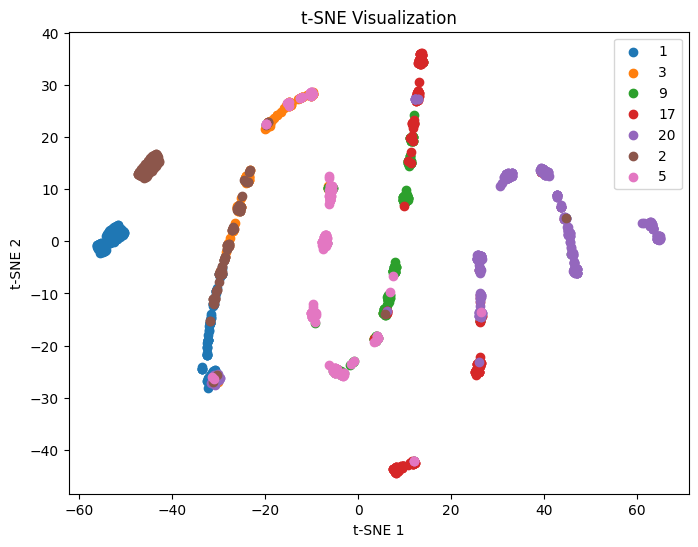

In [58]:
import matplotlib.pyplot as plt

# Create a new DataFrame for the t-SNE results
tsne_df = pd.DataFrame(tsne_results, columns=['tsne1', 'tsne2'])
tsne_df['label'] = df['memory_usage_label']

# Remove rows with NaN labels
tsne_df = tsne_df.dropna(subset=['label'])

# Plot the results
plt.figure(figsize=(8, 6))
for label in tsne_df['label'].unique():
    subset = tsne_df[tsne_df['label'] == label]
    plt.scatter(subset['tsne1'], subset['tsne2'], label=label)

plt.title('t-SNE Visualization')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.legend()
plt.show()

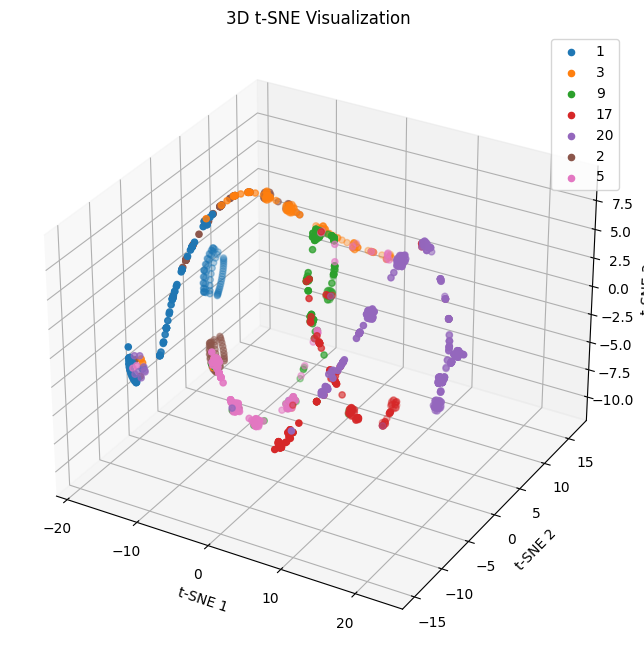

In [59]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D  # For 3D plotting

# Initialize the t-SNE model with 3 components
tsne = TSNE(n_components=3, random_state=43)

# Fit and transform the features
tsne_results = tsne.fit_transform(df[['layers', 'batch_size', 'all_parameters', 'all_activations']])

# Create a new DataFrame for the t-SNE results (3 components)
tsne_df = pd.DataFrame(tsne_results, columns=['tsne1', 'tsne2', 'tsne3'])
tsne_df['label'] = df['memory_usage_label']

# Remove rows with NaN labels
tsne_df = tsne_df.dropna(subset=['label'])

# Plot the results in 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

for label in tsne_df['label'].unique():
    subset = tsne_df[tsne_df['label'] == label]
    ax.scatter(subset['tsne1'], subset['tsne2'], subset['tsne3'], label=label)

# Set plot title and labels
ax.set_title('3D t-SNE Visualization')
ax.set_xlabel('t-SNE 1')
ax.set_ylabel('t-SNE 2')
ax.set_zlabel('t-SNE 3')

# Add legend
plt.legend()

# Show the plot
plt.show()

# PCA

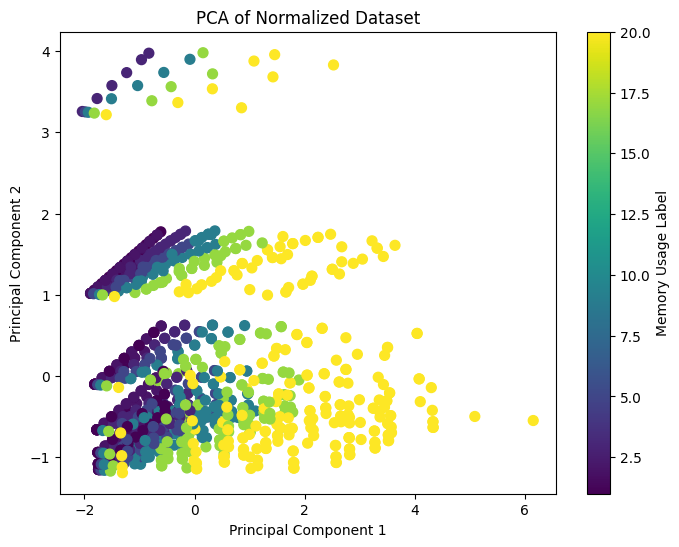

PCA Components:
[[ 0.37574839 -0.06512141  0.62258964  0.68334068]
 [ 0.22322907  0.97278294 -0.0578616   0.02267545]]
Explained variance ratio:
[0.51345314 0.25037322]


In [60]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler  # Import for normalization

# Assuming you have a pandas DataFrame 'df'
# df = pd.read_csv('your_dataset.csv')  # Uncomment if loading from a file

# Example DataFrame columns: 'layers', 'batch_size', 'all_parameters', 'all_activations', 'memory_usage_label'
X = df[['layers', 'batch_size', 'all_parameters', 'all_activations']]  # Input features
y = df['memory_usage_label']  # Output label for coloring

# Normalize the data
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

# Apply PCA to reduce the dataset to 2 dimensions
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_normalized)

# Plotting the PCA-reduced data
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', s=50)
plt.colorbar(label='Memory Usage Label')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Normalized Dataset')

# Show the plot
plt.show()

components = pca.components_

# Get the explained variance ratio for each component (optional, to know how much variance each component explains)
explained_variance = pca.explained_variance_ratio_

# Show the components (each row corresponds to a principal component, each column corresponds to the original feature)
print("PCA Components:")
print(components)

# Show the explained variance ratio for each component
print("Explained variance ratio:")
print(explained_variance)

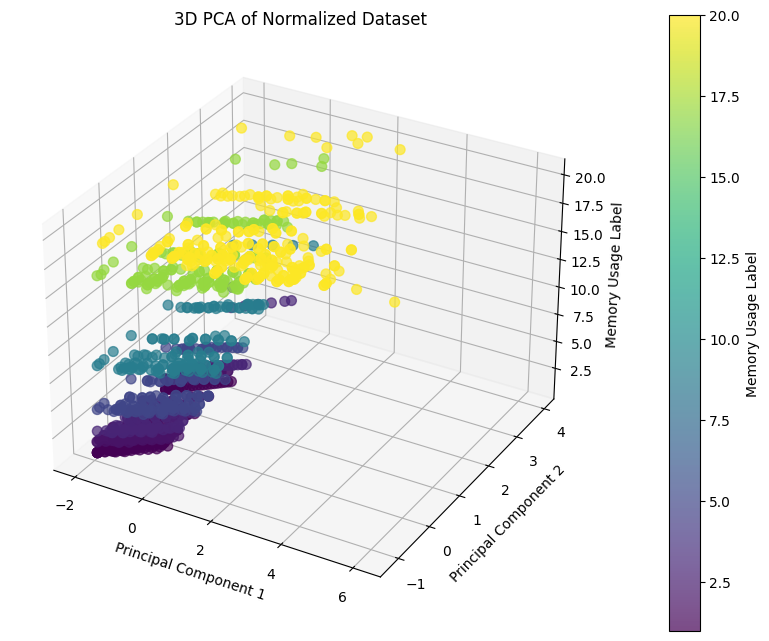

PCA Components:
[[ 0.37574839 -0.06512141  0.62258964  0.68334068]
 [ 0.22322907  0.97278294 -0.0578616   0.02267545]
 [-0.86280651  0.22235504  0.44495197  0.09022695]]
Explained Variance Ratio:
[0.51345314 0.25037322 0.22031048]


In [61]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Import for 3D plotting
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Assuming you have a pandas DataFrame 'df'
# df = pd.read_csv('your_dataset.csv')  # Uncomment if loading from a file

# Example DataFrame columns: 'layers', 'batch_size', 'all_parameters', 'all_activations', 'memory_usage_label'
X = df[['layers', 'batch_size', 'all_parameters', 'all_activations']]  # Input features
y = df['memory_usage_label']  # Output label for coloring

# Normalize the data
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

# Apply PCA to reduce the dataset to 2 dimensions
pca = PCA(n_components=3)  # Change to 3 components for 3D plotting
X_pca = pca.fit_transform(X_normalized)

# Plotting the PCA-reduced data in 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], y, c=y, cmap='viridis', s=50, alpha=0.7)

# Labels and title
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Memory Usage Label')
ax.set_title('3D PCA of Normalized Dataset')

# Colorbar
cbar = plt.colorbar(scatter, ax=ax, pad=0.1)
cbar.set_label('Memory Usage Label')

# Show the plot
plt.show()

# Retrieve and display PCA components and explained variance ratio
components = pca.components_
explained_variance = pca.explained_variance_ratio_

print("PCA Components:")
print(components)

print("Explained Variance Ratio:")
print(explained_variance)


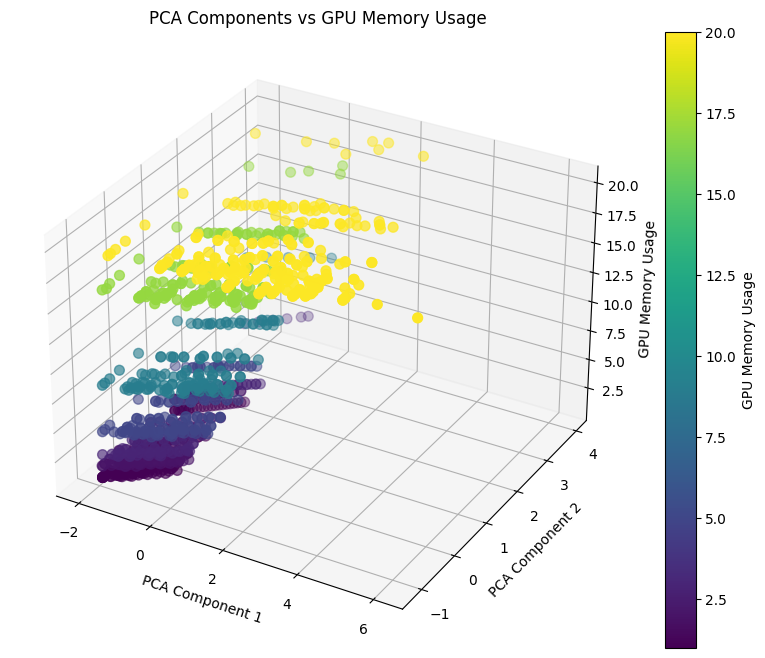

PCA Components:
[[ 0.37574839 -0.06512141  0.62258964  0.68334068]
 [ 0.22322907  0.97278294 -0.0578616   0.02267545]]
Explained variance ratio:
[0.51345314 0.25037322]


In [62]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D

# Example DataFrame columns: 'layers', 'batch_size', 'all_parameters', 'all_activations', 'memory_usage_label'
# Assuming you have a pandas DataFrame 'df'
# df = pd.read_csv('your_dataset.csv')  # Uncomment if loading from a file

# Prepare data
X = df[['layers', 'batch_size', 'all_parameters', 'all_activations']]  # Input features
y = df['memory_usage_label']  # Actual GPU memory usage

# Normalize the data
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

# Apply PCA to reduce the dataset to 2 dimensions
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_normalized)

# Extract PCA components
pca1 = X_pca[:, 0]
pca2 = X_pca[:, 1]

# Plotting the PCA-reduced data with GPU memory usage as z-axis
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
scatter = ax.scatter(pca1, pca2, y, c=y, cmap='viridis', s=50)
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('GPU Memory Usage')
ax.set_title('PCA Components vs GPU Memory Usage')

# Color bar
cbar = plt.colorbar(scatter, ax=ax, label='GPU Memory Usage')
plt.show()

# Output PCA components and explained variance ratio
components = pca.components_
explained_variance = pca.explained_variance_ratio_

print("PCA Components:")
print(components)

print("Explained variance ratio:")
print(explained_variance)


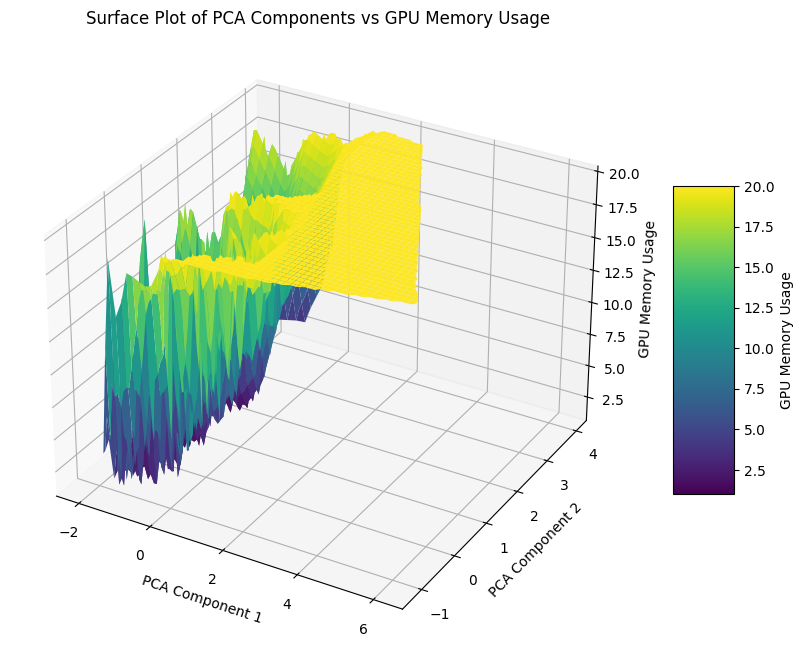

PCA Components:
[[ 0.37574839 -0.06512141  0.62258964  0.68334068]
 [ 0.22322907  0.97278294 -0.0578616   0.02267545]]
Explained variance ratio:
[0.51345314 0.25037322]


In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.interpolate import griddata

# Example DataFrame columns: 'layers', 'batch_size', 'all_parameters', 'all_activations', 'memory_usage_label'
# Assuming you have a pandas DataFrame 'df'
# df = pd.read_csv('your_dataset.csv')  # Uncomment if loading from a file

# Prepare data
X = df[['layers', 'batch_size', 'all_parameters', 'all_activations']]  # Input features
y = df['memory_usage_label']  # Actual GPU memory usage

# Normalize the data
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

# Apply PCA to reduce the dataset to 2 dimensions
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_normalized)

# Extract PCA components
pca1 = X_pca[:, 0]
pca2 = X_pca[:, 1]

# Create grid for surface plot
pca1_grid, pca2_grid = np.meshgrid(np.linspace(pca1.min(), pca1.max(), 100),
                                   np.linspace(pca2.min(), pca2.max(), 100))

# Interpolate to fit the GPU memory usage on the grid
memory_usage_grid = griddata((pca1, pca2), y, (pca1_grid, pca2_grid), method='linear')

# Plotting the PCA-reduced data with GPU memory usage as a surface
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot surface
surf = ax.plot_surface(pca1_grid, pca2_grid, memory_usage_grid, cmap='viridis', edgecolor='none')
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('GPU Memory Usage')
ax.set_title('Surface Plot of PCA Components vs GPU Memory Usage')

# Add color bar
cbar = fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)
cbar.set_label('GPU Memory Usage')

plt.show()

# Output PCA components and explained variance ratio
components = pca.components_
explained_variance = pca.explained_variance_ratio_

print("PCA Components:")
print(components)

print("Explained variance ratio:")
print(explained_variance)

# regression model

In [ ]:
columns_to_normalize = ['real_memory_usage', 'layers', 'batch_size', 'all_parameters', 'all_activations']

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler and transform the data
# df_normalized_reg = pd.DataFrame(scaler.fit_transform(df[columns_to_normalize]), columns=columns_to_normalize)
df_normalized_reg = df


In [34]:
from sklearn.model_selection import train_test_split
x_train_reg, x_temp_reg, y_train_reg, y_temp_reg = train_test_split(
    df_normalized_reg[['layers', 'batch_size', 'all_parameters', 'all_activations']].values, df_normalized_reg['real_memory_usage'].values, test_size=0.3, random_state=42)

x_test_reg, x_val_reg, y_test_reg, y_val_reg = train_test_split(
    x_temp_reg, y_temp_reg, test_size=0.66, random_state=42)

print('total data size: ', len(df))
print(f"train size {len(x_train_reg)}, val size: {len(x_val_reg)}, test size: {len(x_test_reg)}")

total data size:  1086
train size 760, val size: 216, test size: 110


In [35]:
train_dataloader_reg = DataLoader(CustomDataset(x_train_reg, y_train_reg), 64, num_workers=2, shuffle=True)
val_dataloader_reg = DataLoader(CustomDataset(x_val_reg, y_val_reg), 64, num_workers=2)
test_dataloader_reg = DataLoader(CustomDataset(x_test_reg, y_test_reg),1, num_workers=1)
x, y = next(iter(train_dataloader_reg))
print(f"input shape: {x.shape}, output shape: {y.shape}")

input shape: torch.Size([64, 4]), output shape: torch.Size([64])


In [ ]:
class regression_gpu_usage(pl.LightningModule):
    def __init__(self):
        super(regression_gpu_usage, self).__init__()
        self.model = FC_base(input_features=4, output_features=1, base_features=4)
        # self.criterion = nn.MSELoss()
        self.criterion = nn.L1Loss()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch[0], batch[1]
        # y = y.long()
        logits = self.forward(x)
        loss = self.criterion(logits, y)
        self.log('train_loss', loss, on_epoch=True, on_step=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch[0], batch[1]
        # y = y.long()
        logits = self.forward(x)
        loss = self.criterion(logits, y)
        self.log('val_loss', loss, prog_bar=True, on_epoch=True, on_step=True)
        return loss

    def configure_optimizers(self):
        # Create a quantized optimizer
        optimizer = Adam(self.parameters(), lr=0.0001)
        return optimizer



In [40]:
# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=True, mode='min')

# Initialize the model
regression_model = regression_gpu_usage()
regression_model.train()
trainer = pl.Trainer(
    max_epochs=400,  
    callbacks=[early_stopping],
)

# Train the model
trainer.fit(regression_model, train_dataloaders=train_dataloader_reg, val_dataloaders=val_dataloader_reg)



Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name      | Type    | Params | Mode 
----------------------------------------------
0 | model     | FC_base | 89     | train
1 | criterion | L1Loss  | 0      | train
----------------------------------------------
89        Trainable params
0         Non-trainable params
89        Total params
0.000     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved. New best score: 13622.269


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 13622.264


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 13622.255


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 13622.245


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.021 >= min_delta = 0.0. New best score: 13622.225


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.032 >= min_delta = 0.0. New best score: 13622.192


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.017 >= min_delta = 0.0. New best score: 13622.176


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.023 >= min_delta = 0.0. New best score: 13622.152


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 13622.148


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 13622.142


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.021 >= min_delta = 0.0. New best score: 13622.120


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.014 >= min_delta = 0.0. New best score: 13622.106


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 13622.095


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 13622.088


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 13622.080


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 13622.067


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 13622.061


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 13622.056


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.014 >= min_delta = 0.0. New best score: 13622.042


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 13622.036


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 13622.026


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 13622.017


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 13622.006


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 13622.005


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 13621.993


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 13621.982


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 13621.976


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.014 >= min_delta = 0.0. New best score: 13621.962


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 13621.956


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 13621.941


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 13621.939


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 13621.936


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 13621.926


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 13621.925


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 13621.914


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 13621.913


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.018 >= min_delta = 0.0. New best score: 13621.896


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 13621.895


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 13621.892


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 13621.888


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 13621.882


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 13621.871


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 13621.867


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 13621.864


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 13621.858


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 13621.853


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 13621.849


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 13621.848


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 13621.843


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 13621.830


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 13621.827


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 13621.821


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.014 >= min_delta = 0.0. New best score: 13621.808


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 13621.801


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 13621.794


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 13621.787


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 13621.785


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 13621.776


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 13621.770


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 13621.764


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 13621.756


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 13621.754


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 13621.748


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 13621.735


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 13621.726


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 13621.725


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 13621.715


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 13621.711


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 13621.699


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 13621.698


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 13621.694


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.019 >= min_delta = 0.0. New best score: 13621.676


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 13621.667


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 13621.665


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 13621.662


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 13621.654


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.017 >= min_delta = 0.0. New best score: 13621.638


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 13621.634


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 13621.632


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 13621.626


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 13621.614


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 13621.610


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 13621.604


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 13621.599


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 13621.594


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 13621.589


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.021 >= min_delta = 0.0. New best score: 13621.567


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 13621.566


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 13621.561


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 13621.556


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 13621.550


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 13621.539


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 13621.536


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 13621.535


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.017 >= min_delta = 0.0. New best score: 13621.519


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 13621.517


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 13621.515


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 13621.512


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.017 >= min_delta = 0.0. New best score: 13621.495


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 13621.485


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 13621.478


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 13621.470


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 13621.462


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 13621.454


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.017 >= min_delta = 0.0. New best score: 13621.438


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 13621.429


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.021 >= min_delta = 0.0. New best score: 13621.407


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 13621.405


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 13621.396


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 13621.393


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.016 >= min_delta = 0.0. New best score: 13621.377


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.017 >= min_delta = 0.0. New best score: 13621.360


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 13621.358


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 13621.353


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 13621.349


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 13621.343


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 13621.336


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 13621.321


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 13621.309


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 13621.306


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 13621.294


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 13621.285


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 13621.281


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 13621.267


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.021 >= min_delta = 0.0. New best score: 13621.245


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 13621.243


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 13621.238


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 13621.233


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 13621.232


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 13621.226


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 13621.219


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 13621.207


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 13621.195


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.014 >= min_delta = 0.0. New best score: 13621.182


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 13621.173


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 13621.164


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 13621.163


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.025 >= min_delta = 0.0. New best score: 13621.138


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 13621.127


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 13621.116


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 13621.106


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 13621.102


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 13621.094


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.020 >= min_delta = 0.0. New best score: 13621.074


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 13621.062


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 13621.055


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 13621.048


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 13621.036


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 13621.027


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 13621.021


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 13621.012


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 13621.001


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 13620.992


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 13620.991


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 13620.986


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.016 >= min_delta = 0.0. New best score: 13620.971


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.020 >= min_delta = 0.0. New best score: 13620.951


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 13620.943


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 13620.937


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 13620.933


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.021 >= min_delta = 0.0. New best score: 13620.912


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 13620.910


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 13620.907


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 13620.902


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.017 >= min_delta = 0.0. New best score: 13620.886


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 13620.880


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.014 >= min_delta = 0.0. New best score: 13620.866


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 13620.858


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.021 >= min_delta = 0.0. New best score: 13620.837


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 13620.831


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.019 >= min_delta = 0.0. New best score: 13620.812


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.021 >= min_delta = 0.0. New best score: 13620.792


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 13620.785


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.019 >= min_delta = 0.0. New best score: 13620.767


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.037 >= min_delta = 0.0. New best score: 13620.729


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 13620.717


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 13620.708


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.026 >= min_delta = 0.0. New best score: 13620.682


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.018 >= min_delta = 0.0. New best score: 13620.664


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 13620.660


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.017 >= min_delta = 0.0. New best score: 13620.644


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.014 >= min_delta = 0.0. New best score: 13620.630


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.021 >= min_delta = 0.0. New best score: 13620.608


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 13620.607


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.021 >= min_delta = 0.0. New best score: 13620.587


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.033 >= min_delta = 0.0. New best score: 13620.554


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.059 >= min_delta = 0.0. New best score: 13620.495


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.016 >= min_delta = 0.0. New best score: 13620.479


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 13620.468


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.018 >= min_delta = 0.0. New best score: 13620.450


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.035 >= min_delta = 0.0. New best score: 13620.415


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 13620.400


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.030 >= min_delta = 0.0. New best score: 13620.370


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.053 >= min_delta = 0.0. New best score: 13620.317


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.035 >= min_delta = 0.0. New best score: 13620.282


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.040 >= min_delta = 0.0. New best score: 13620.242


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.030 >= min_delta = 0.0. New best score: 13620.212


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.025 >= min_delta = 0.0. New best score: 13620.187


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 13620.175


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 13620.165


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.039 >= min_delta = 0.0. New best score: 13620.126


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 13620.113


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.023 >= min_delta = 0.0. New best score: 13620.090


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.032 >= min_delta = 0.0. New best score: 13620.058


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 13620.055


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric val_loss did not improve in the last 10 records. Best score: 13620.055. Signaling Trainer to stop.


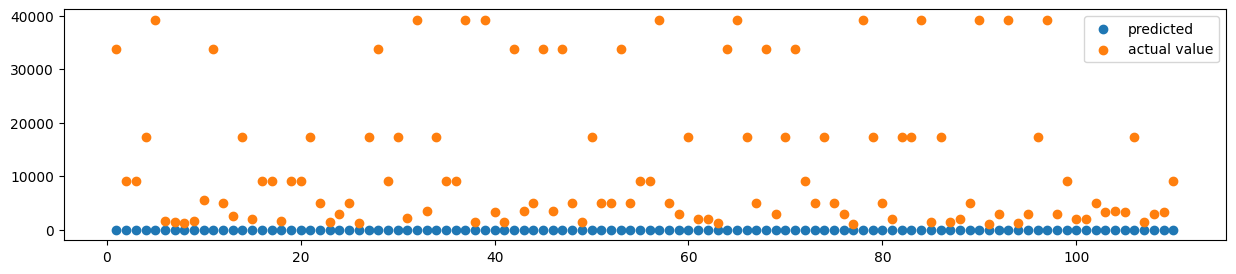

In [41]:
regression_model.eval()
pred_list, gt = list(), list()
with torch.no_grad():
    for test_data in test_dataloader_reg:
        pred = regression_model(test_data[0])
        # print(f"prediction: {torch.argmax(pred, 1)}, ground truth: {test_data[1]}")
        gt.append(test_data[1].item())
        pred_list.append(pred.item())
        # print(f"prediction: {pred.item()}, gt: {test_data[1].item()}")

plt.figure(figsize=(15, 3))
plt.scatter(range(1, len(pred_list) + 1), pred_list, label="predicted")
plt.scatter(range(1, len(gt) + 1), gt, label="actual value")
plt.legend()